In [16]:
##Gather Data for Grating Calibration
import serial
import time

# Open serial port
with serial.Serial('COM6', 9600) as ser:
    #delay 1 second4
    time.sleep(1)

    #home the grating with '0' command
    ser.write(b'0\r\n')
    print('Homing grating...')

    #wait for 'OK' response
    while True:
        response = ser.readline()
        if response == b'OK\r\n':
            break

    print('Grating homed.')

    #enter automation mode by sending '8' command
    ser.write(b'8\r\n')

    print('Entering automation mode...')

    #move to an initial position with '6 50000' command
    ser.write(b'6 50000\r\n')
    print('Moving to initial position...')
    while True:
        response = ser.readline()
        if response == b'OK\r\n':
            break

    #command the grating to move 1000 steps with '6 5000' command for a total of 200 measurements
    for i in range(199):
        ser.write(b'6 1000\r\n')
        print(f'Moving to next position...{i+2}')
        while True:
            response = ser.readline()
            if response == b'OK\r\n':
                break
        
    #exit automation mode by sending '8' command
    ser.write(b'8\r\n')
    print('Exiting automation mode...')



Homing grating...
Grating homed.
Entering automation mode...
Moving to initial position...
Moving to next position...2
Moving to next position...3
Moving to next position...4
Moving to next position...5
Moving to next position...6
Moving to next position...7
Moving to next position...8
Moving to next position...9
Moving to next position...10
Moving to next position...11
Moving to next position...12
Moving to next position...13
Moving to next position...14
Moving to next position...15
Moving to next position...16
Moving to next position...17
Moving to next position...18
Moving to next position...19
Moving to next position...20
Moving to next position...21
Moving to next position...22
Moving to next position...23
Moving to next position...24
Moving to next position...25
Moving to next position...26
Moving to next position...27
Moving to next position...28
Moving to next position...29
Moving to next position...30
Moving to next position...31
Moving to next position...32
Moving to next pos

(1348, 203)
(1348,)
(200, 1348)


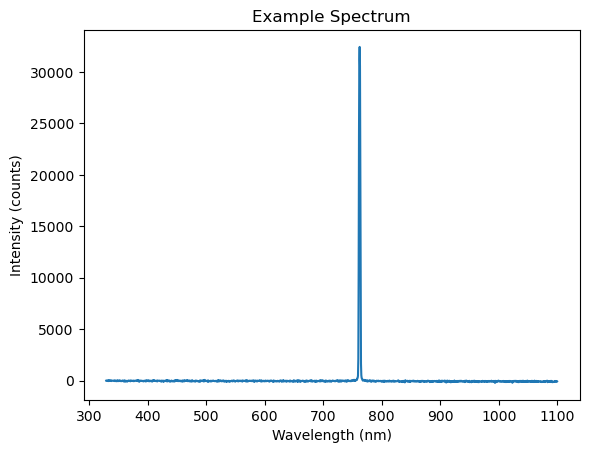

In [1]:
##Open and read data from the grating calibration file
import numpy as np
import matplotlib.pyplot as plt

filename = '200_11OCT_1507066U1.TXT'

#open file
data = np.genfromtxt(filename, delimiter = ';', skip_header = 10, filling_values=np.nan)

print(data.shape)

wavelengths = data[:,0].astype(float)
intensities = data[:,3:].astype(float).T

print(wavelengths.shape)
print(intensities.shape)

#print an example spectrum - many have two peaks due to grating artifacts, we only need the higher wavelength peak
plt.plot(wavelengths, intensities[96])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (counts)')
plt.title('Example Spectrum')
plt.show()

first_good_measurement = 15
last_good_measurement = 160

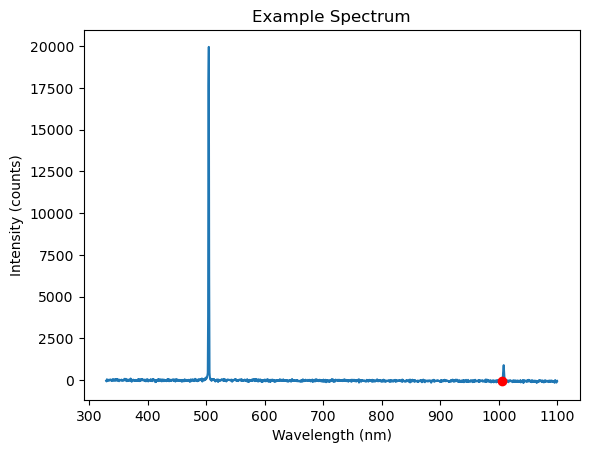

In [2]:
##fit gaussian to each spectrum and plot the peak wavelength as a function of grating position
from scipy.optimize import curve_fit

#function to fit gaussian to spectrum
def gaussian(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

#estimate the peak centroid of the right most peak in each spectrum
def estimateCentroid(x):
    #start at the right most point and decrement until a prominence of 200 is reached
    for i in range(len(x)-1, 0, -1):
        if x[i] - x[i-1] > 250:
            break
    #continue decrementing until while the values are still increasing
    while x[i] - x[i-1] > 0:
        i -= 1

    #return the index of the peak
    return i

#test the estimateCentroid function and plot the result for a single spectrum
testIdx = 175
test = estimateCentroid(intensities[testIdx])
plt.plot(wavelengths, intensities[testIdx])
plt.plot(wavelengths[test], intensities[testIdx][test], 'ro')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (counts)')
plt.title('Example Spectrum')
plt.show()

#fit gaussian to each spectrum and plot the peak wavelength as a function of grating position
popt = np.zeros((last_good_measurement-first_good_measurement, 3))
for i in range(first_good_measurement, last_good_measurement):
    estCentroidIdx = estimateCentroid(intensities[i])
    estCentroid = wavelengths[estCentroidIdx]
    #fit a gaussian to the spectrum with the surrounding 100 points
    popt[i-first_good_measurement], pcov = curve_fit(gaussian, wavelengths[estCentroidIdx-50:estCentroidIdx+50], intensities[i][estCentroidIdx-50:estCentroidIdx+50], p0 = [1, estCentroid, 1])

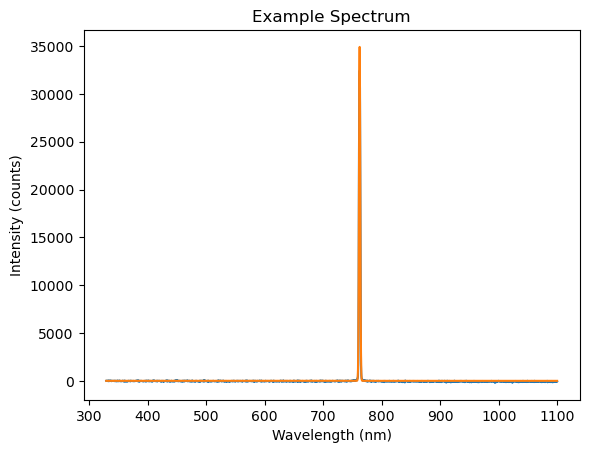

In [4]:
#plot an example fit
plt.plot(wavelengths, intensities[96])
plt.plot(wavelengths, gaussian(wavelengths, *popt[96-first_good_measurement]))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (counts)')
plt.title('Example Spectrum')
plt.show()

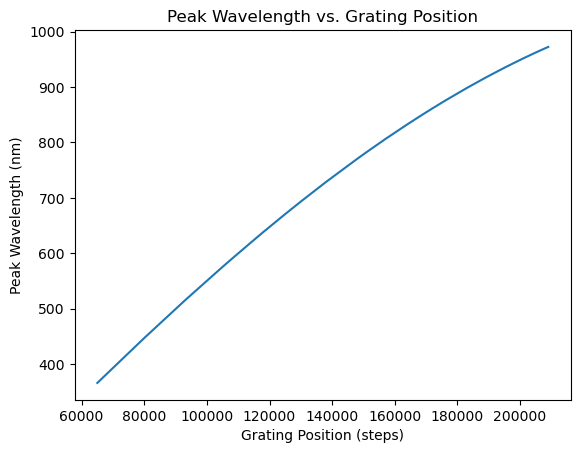

In [5]:
#plot the peak wavelength as a function of grating position

#the grating position started at 50000 and indexed 1000 steps for each measurement
grating_position = np.arange(first_good_measurement, last_good_measurement)*1000 + 50000

plt.plot(grating_position, popt[:,1])
plt.xlabel('Grating Position (steps)')
plt.ylabel('Peak Wavelength (nm)')
plt.title('Peak Wavelength vs. Grating Position')
plt.show()

w == wavelength
Grating Position = 2.486e-04 w^3 + -4.007e-01 w^2 + 4.942e+02 w + -3.917e+03
return (2.486e-04 * pow(wavelength, 3) + -4.007e-01 * pow(wavelength, 2) + 4.942e+02 * wavelength + -3.917e+03)
w == wavelength
Grating Position = 2.486e-04 w^3 + -4.007e-01 w^2 + 4.942e+02 w + -3.917e+03


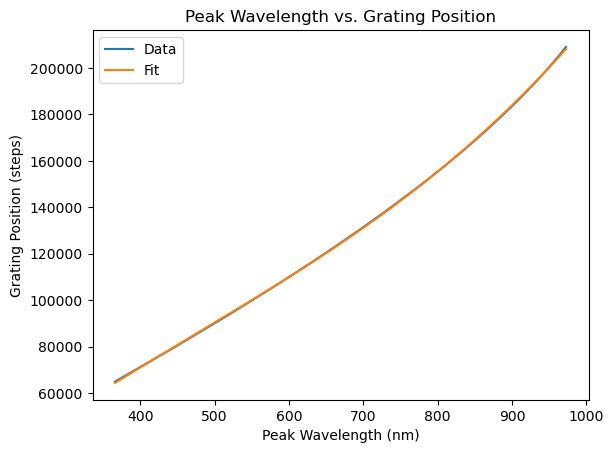

In [17]:
#use a monotonically increasing function to fit the data
def grating_wavelength_to_position(wavelength, a, b, c, d):
    return a * wavelength**3 + b * wavelength**2 + c * wavelength + d * np.sqrt(wavelength)

#fit the grating equation to the data
popt2, pcov2 = curve_fit(grating_wavelength_to_position, popt[:,1], grating_position)

# print the grating_wavelength_to_position in a readable format, using w rather than wavelength
print('w == wavelength')
print(f'Grating Position = {popt2[0]:.3e} w^3 + {popt2[1]:.3e} w^2 + {popt2[2]:.3e} w + {popt2[3]:.3e}')

#print the function so it can be copied into a c++ program
print(f'return ({popt2[0]:.3e} * pow(wavelength, 3) + {popt2[1]:.3e} * pow(wavelength, 2) + {popt2[2]:.3e} * wavelength + {popt2[3]:.3e})')

#plot the fit
plt.plot(popt[:,1], grating_position, label = 'Data')
plt.plot(popt[:,1], grating_wavelength_to_position(popt[:,1], *popt2), label = 'Fit')
plt.xlabel('Peak Wavelength (nm)')
plt.ylabel('Grating Position (steps)')
plt.title('Peak Wavelength vs. Grating Position')
plt.legend()
plt.show()

